# Module 6 : Web search

## Show the evidence that you have be able to follow (codes and running results) the walkthrough
(1) Develop a simple web crawler (pg 33-38)

(2) Indexing using Solr (pg 43-48)

(3) Indexing using Elasticsearch (pg 52-55)

(4) Calculate the Pagerank score (pg 70-74)

(4) Boost the ranking score using the Pagerank for both Solr and Elasticsearch (pg 75-77)

# Preparing the library

In [1]:
import os

import pysolr
import requests
import multiprocessing
import pickle
import json
from bs4 import BeautifulSoup
from bs4.element import Comment
from queue import Queue, Empty
from concurrent.futures import ThreadPoolExecutor
from urllib.parse import urlparse, urljoin
from pathlib import Path

from elasticsearch import Elasticsearch

## 1 Simple Web Crawler

In [2]:
class MultiThreadCrawler:
    def __init__(self, base_url, depth):
        self.base_url = base_url
        extracted_url = urlparse(base_url)
        parent = extracted_url.path[:extracted_url.path.rfind("/") + 1]
        self.root_url = '{}://{}{}'.format(extracted_url.scheme, extracted_url.netloc, parent)
        self.pool = ThreadPoolExecutor(max_workers=multiprocessing.cpu_count() - 1)
        self.to_crawl = Queue()
        self.to_crawl.put({self.base_url: depth})
        self.stored_folder = Path("E:/CMU/953/IR481/Module6").parent / '../crawled/'

        if not Path(self.stored_folder).exists():
            Path.mkdir(self.stored_folder)
            
        if Path(self.stored_folder / 'url_list.pickle').exists():
            with open(self.stored_folder / 'url_list.pickle', 'rb') as f:
                self.crawled_pages = pickle.load(f)
            print(self.crawled_pages)
        else:
            self.crawled_pages = set([])
            
    def run_scraper(self):
        while True:
            try:
                target = self.to_crawl.get(timeout=10)
                url, depth = [(k, target[k]) for k in target][0]
                if url not in self.crawled_pages:
                    self.crawled_pages.add(url)
                    job = self.pool.submit(self.get_page, url, depth - 1)
                    job.add_done_callback(self.extract_page)
            except Empty:
                with open(self.stored_folder / 'url_list.pickle', 'wb') as f:
                    pickle.dump(self.crawled_pages, f, pickle.HIGHEST_PROTOCOL)
                with open(self.stored_folder / 'url_list.pickle', 'rb') as f:
                    print(pickle.load(f))
                break
            except Exception as e:
                print(e)
                continue
                
    def extract_page(self, obj):
        if obj.result():
            result, url, depth = obj.result()
            if result and result.status_code == 200:
                url_lists = self.parse_links(result.text, depth)
                self.parse_contents(url, result.text, url_lists)
                
    def get_page(self, url, depth):
        try:
            res = requests.get(url, timeout=(3, 30))
            return res, url, depth
        except requests.RequestException:
            return
        
    def parse_links(self, html, depth):
        soup = BeautifulSoup(html, 'html.parser')
        links = soup.find_all('a', href=True)
        url_lists = []
        for link in links:
            url = link['href']
            url = urljoin(self.root_url, url)
            if depth >= 0 and '..' not in url and url not in self.crawled_pages:
                print("Adding {}".format(url))
                self.to_crawl.put({url: depth})
            url_lists.append(url)
        return url_lists
    
    def parse_contents(self, url, html, url_lists):
        def tag_visible(element):
            if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
                return False
            if isinstance(element, Comment):
                return False
            return True

        try:
            soup = BeautifulSoup(html, 'html.parser')
            texts = soup.findAll(text=True)
            visible_texts = filter(tag_visible, texts)
            title = soup.find('title').string.strip()
            text = u" ".join(t.strip() for t in visible_texts).strip()
            with open(self.stored_folder / (str(hash(url)) + '.txt'), 'w', encoding='utf-8') as f:
                json.dump({'url': url, 'title': title, 'text': text, 'url_lists': url_lists}, f, ensure_ascii=False)
        except:
            pass

In [3]:
s = MultiThreadCrawler("https://camt.cmu.ac.th/index.php/en/", 1)
s.run_scraper()

{'https://camt.cmu.ac.th/index.php/en/'}
{'https://camt.cmu.ac.th/index.php/en/'}


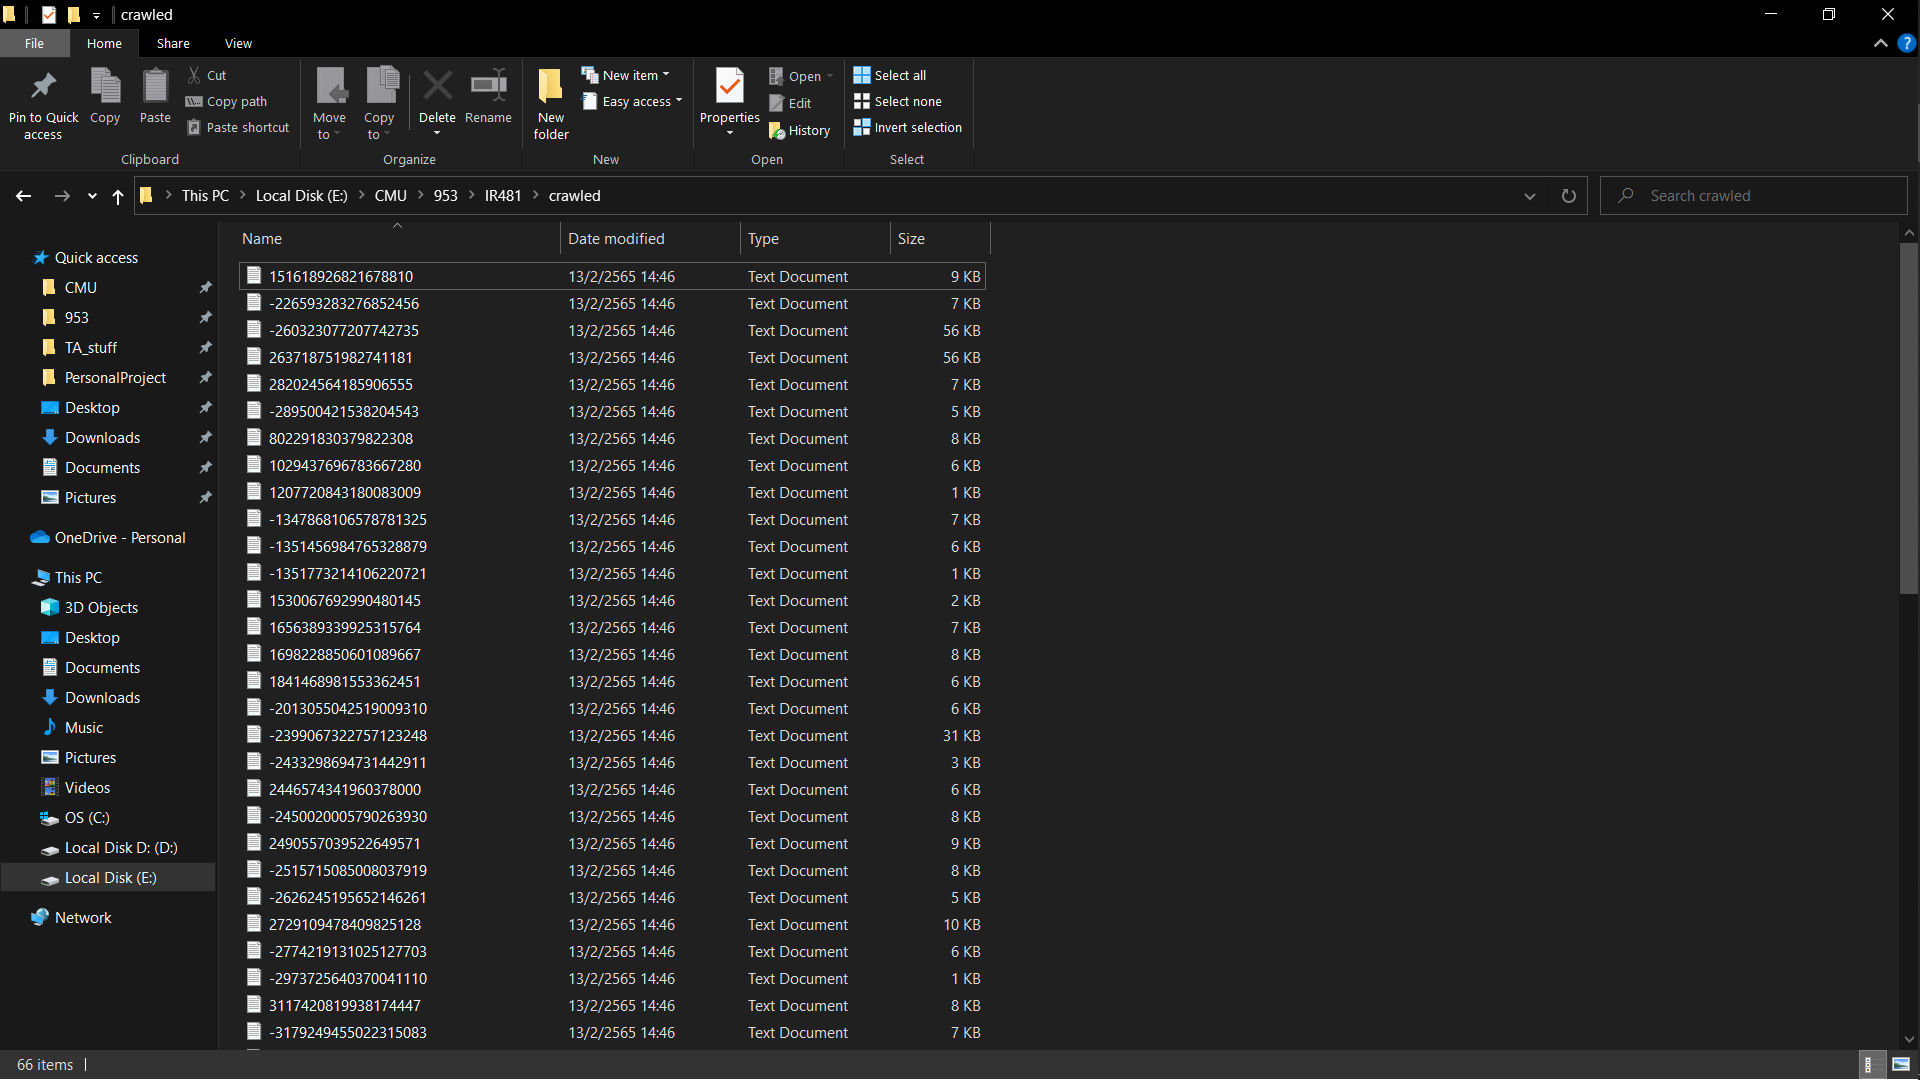

## 2. Indexing using Solr (pg 43-48)

In [15]:
class Indexing :
    def __init__(self):
        self.crawled_folder = Path("E:/CMU/953/IR481/").parent / '../crawled/'
        with open(self.crawled_folder / 'url_list.pickle', 'rb') as f:
            self.file_mapper = pickle.load(f)
        self.solr = pysolr.Solr('http://localhost:8983/solr/simple', always_commit=True, timeout=10)
        
    def run_indexing(self):
        self.solr.delete(q='*:*')
        for file in os.listdir(self.crawled_folder):
            if file.endswith(".txt"):
                j = json.load(open(os.path.join(self.crawled_folder, file),encoding='utf8'))
                j['id'] = j['url']
                print(j)
                self.solr.add(j)

In [17]:
s = Indexing()
s.run_indexing()
results = s.solr.search('text:camt')
for result in results:
    print("The title is '{0} ({1})'.".format(result['title'], result['url']))

### Scarping using Solr

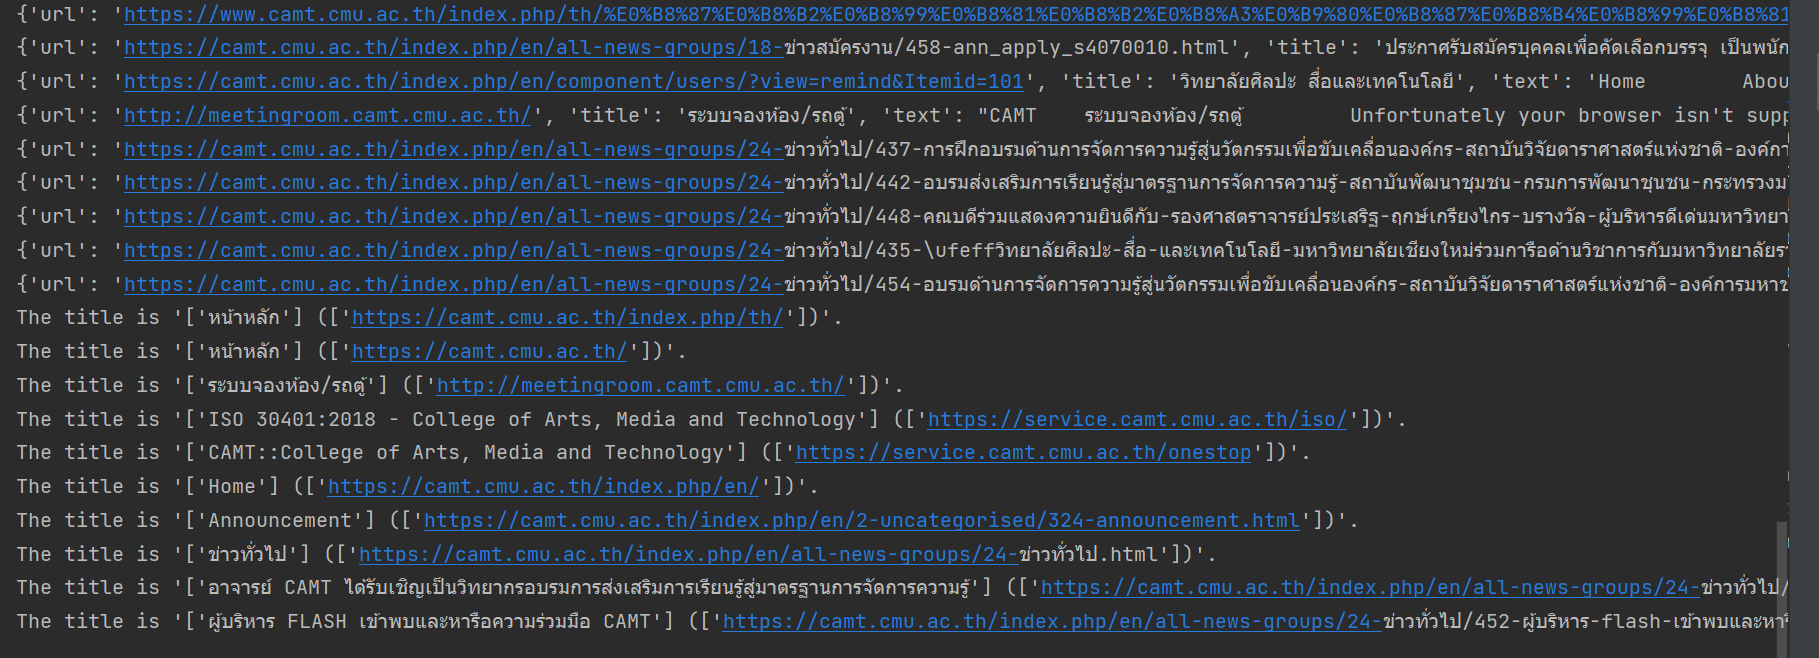

### The Solr itself

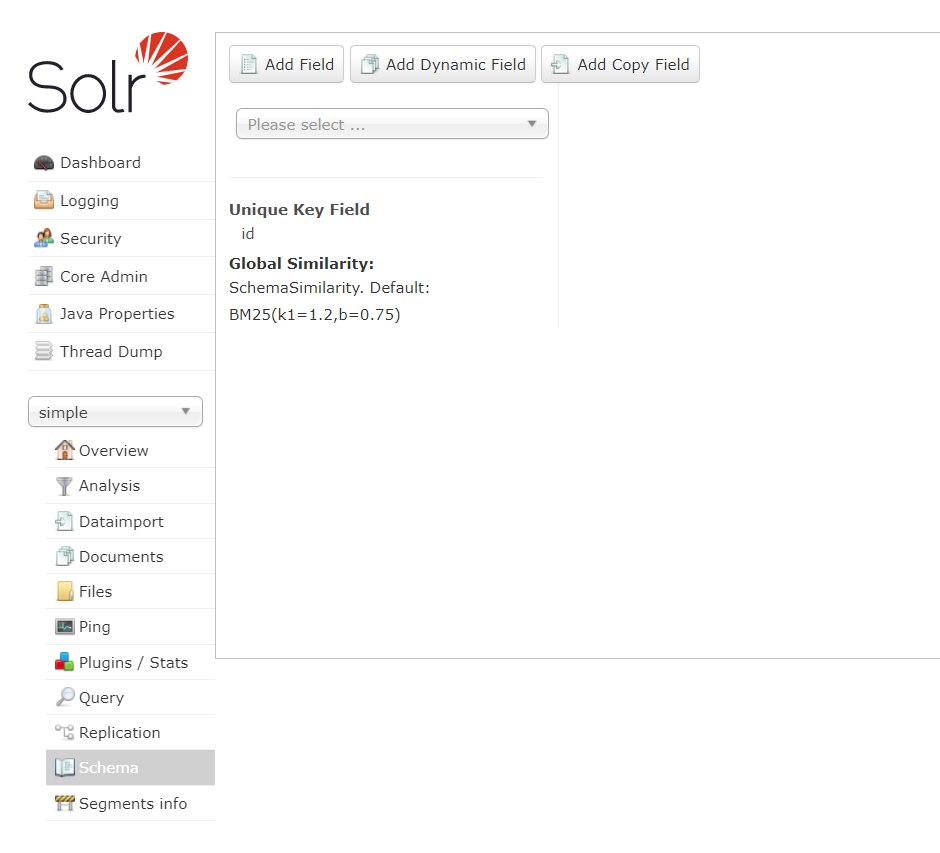

## 3.Indexing using Elasticsearch (pg 52-55)

In [18]:
class Elastic :
    def __init__(self):
        self.crawled_folder = Path(__file__).parent / '../crawled/'
        with open(self.crawled_folder / 'url_list.pickle', 'rb') as f:
            self.file_mapper = pickle.load(f)
        self.es_client = Elasticsearch("localhost:9200", http_auth=["elastic", "changeme"], )
    
    def run_indexer(self):
        self.es_client.indices.create(index='simple', ignore=400)
        self.es_client.indices.delete(index='simple', ignore=[400, 404])

        for file in os.listdir(self.crawled_folder):
            if file.endswith(".txt"):
                j = json.load(open(os.path.join(self.crawled_folder, file), encoding='utf-8'))
                j['id'] = j['url']
                print(j)
                self.es_client.index(index='simple', body=j)

In [20]:
s = Elastic()
s.run_indexer()
query = {'query': {'bool': {'must': [{'match': {'text': 'camt'}}]}}}
results = s.es_client.search(index='simple', body=query)
print("Got %d Hits:" % results['hits']['total']['value'])
for hit in results['hits']['hits']:
    print("The title is '{0} ({1})'.".format(hit["_source"]['title'], hit["_source"]['url']))

## 4.Calculate the Pagerank score (pg 70-74)

### The basic formula

In [23]:
import numpy as np
def power_iteration():
    x0 = np.matrix([1/7] * 7)
    P = np.matrix([
        [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7],
        [25/56, 3/140, 25/56, 3/140, 3/140, 3/140, 3/140],
        [3/140, 3/140, 3/140, 3/140, 61/70, 3/140, 3/140],
        [3/140, 3/140, 25/56, 3/140, 3/140, 3/140, 25/56],
        [25/56, 3/140, 3/140, 3/140, 3/140, 25/56, 3/140],
        [3/140, 3/140, 61/70, 3/140, 3/140, 3/140, 3/140],
        [3/140, 3/140, 25/56, 3/140, 3/140, 25/56, 3/140],
        ])

    prev_Px = x0
    Px = x0*P
    i=0
    while(any(abs(np.asarray(prev_Px).flatten()-np.asarray(Px).flatten()) > 1e-8)):
        i += 1
        prev_Px = Px
        Px = Px * P

    print('Converged in {0} iterations: {1}'.format(i, np.asarray(Px).flatten()))

In [24]:
power_iteration()

Converged in 39 iterations: [0.16911688 0.04196419 0.25324048 0.04196419 0.2572186  0.17669667
 0.05979897]


### The page rank

In [25]:
class PageRank:
    def __init__(self, alpha):
        self.crawled_folder = Path(__file__).parent / '../crawled/'
        self.alpha = alpha

    def url_extractor(self):
        url_maps = {}
        all_urls = set([])

        for file in os.listdir(self.crawled_folder):
            if file.endswith(".txt"):
                j = json.load(open(os.path.join(self.crawled_folder, file), encoding="utf8"))
                all_urls.add(j['url'])
                for s in j['url_lists']:
                    all_urls.add(s)
                url_maps[j['url']] = list(set(j['url_lists']))
        return url_maps, all_urls

    def pr_calc(self):
        url_maps, all_urls = self.url_extractor()
        url_matrix = pd.DataFrame(columns=all_urls,index=all_urls)

        for url in url_maps:
            if len(url_maps[url]) > 0 and len(all_urls) > 0:
                url_matrix.loc[url] = (1 - self.alpha) * (1 / len(all_urls))
                url_matrix.loc[url, url_maps[url]] = url_matrix.loc[url, url_maps[url]] + (self.alpha * (1/len(url_maps[url])))

        url_matrix.loc[url_matrix.isnull().all(axis=1), :] = (1 / len(all_urls))
        x0 = np.matrix([1 / len(all_urls)] * len(all_urls))
        P = np.asmatrix(url_matrix.values)

        prev_Px = x0
        Px = x0 * P
        i = 0
        while (any(abs(np.asarray(prev_Px).flatten() - np.asarray(Px).flatten()) > 1e-8)):
            i += 1
            prev_Px = Px
            Px = Px * P

        print('Converged in {0} iterations: {1}'.format(i, np.around(np.asarray(Px).flatten().astype(float), 5)))
        self.pr_result = pd.DataFrame(Px, columns=url_matrix.index, index=['score']).T.loc[list(url_maps.keys())]


In [28]:
pr = PageRank(alpha=0.85)
pr.pr_calc()

## PageRank with Solr

In [30]:
class PageRankSolr :
    def __init__(self):
        self.crawled_folder = Path(__file__).parent / '../crawled/'
        with open(self.crawled_folder / 'url_list.pickle', 'rb') as f:
            self.file_mapper = pickle.load(f)
        self.solr = pysolr.Solr('http://localhost:8983/solr/simple', always_commit=True, timeout=10)
        self.pr = Pr(alpha=0.85)
        self.pr.pr_calc()

    def run_indexer(self):
        self.solr.delete(q='*:*')
        for file in os.listdir(self.crawled_folder):
            if file.endswith(".txt"):
                j = json.load(open(os.path.join(self.crawled_folder, file),encoding='utf8'))
                j['id'] = j['url']
                j['pagerank'] = self.pr.pr_result.loc[j['id']].score
                print(j)
                self.solr.add(j)

In [32]:
prs = PageRankSolr()
prs.run_indexer()
results = prs.solr.search('text:camt', **{'defType': 'edismax', 'boost': 'mul(query($q),field(pagerank,min))'})
for result in results:
    print("The title is '{0} ({1})'.".format(result['title'], result['url']))

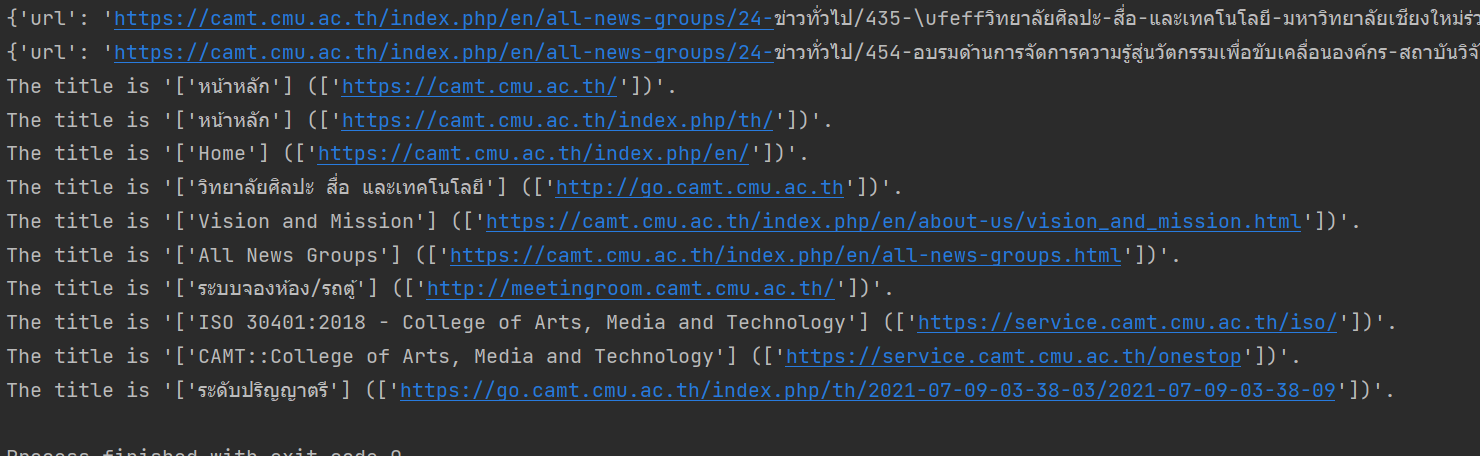

## PageRank with Elasticsearch

In [33]:
class PageRankElasticSearch:
    def __init__(self):
        self.crawled_folder = Path(__file__).parent / '../crawled/'
        with open(self.crawled_folder / 'url_list.pickle', 'rb') as f:
            self.file_mapper = pickle.load(f)
        self.es_client = Elasticsearch("localhost:9200",http_auth=["elastic", "changeme"],)
        self.pr = Pr(alpha = 0.85)
        self.pr.pr_calc()

    def run_indexer(self):
        self.es_client.indices.create(index='simple', ignore=400)
        self.es_client.indices.delete(index='simple', ignore=[400, 404])

        for file in os.listdir(self.crawled_folder):
            if file.endswith(".txt"):
                j = json.load(open(os.path.join(self.crawled_folder, file), encoding='utf8'))
                j['id'] = j['url']
                j['pagerank'] = self.pr.pr_result.loc[j['id']].score
                print(j)
                self.es_client.index(index='simple', body=j)

In [36]:
pres = PageRankElasticSearch()
pres.run_indexer()
query = {"query": {
        "function_score": {
            "query": {
                "match": {
                    "text": "camt"
                }
            },
            "functions": [{
                "field_value_factor": {
                    "field": "pagerank"
                }
            }],
            "score_mode": "multiply"
        }
    }

}
results = pres.es_client.search(index='simple', body=query)
print("Got %d Hits:" % results['hits']['total']['value'])
for hit in results['hits']['hits']:
    print("The title is '{0} ({1})'.".format(hit["_source"]['title'], hit["_source"]['url']))

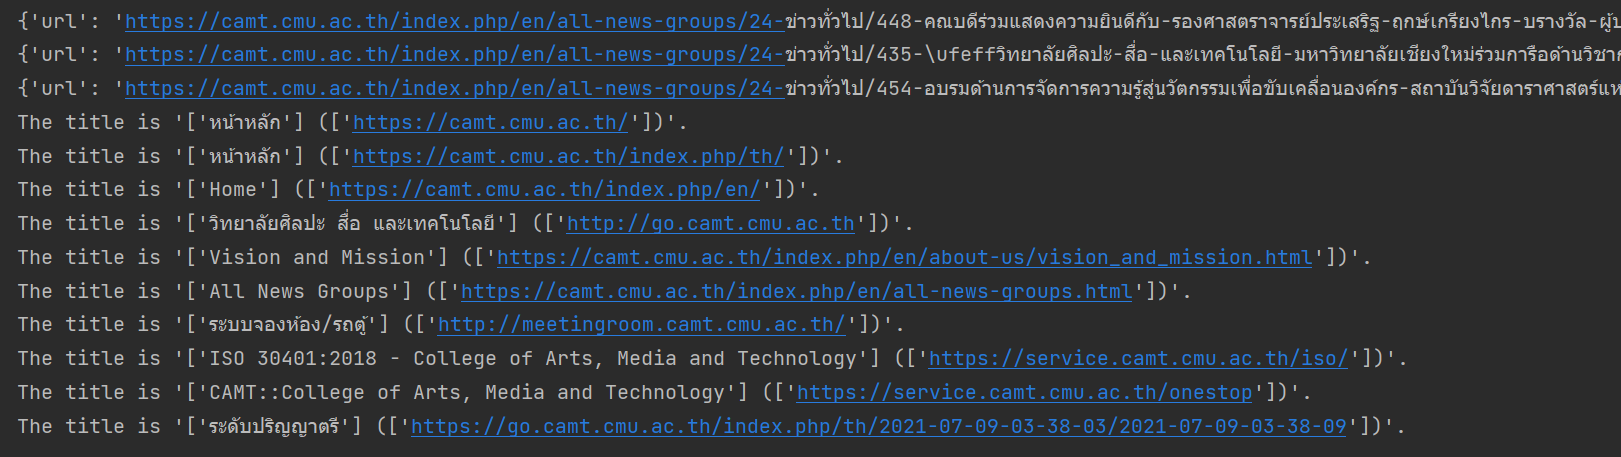

ended handon 6